In [46]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from xgboost import XGBClassifier, XGBRegressor


import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [47]:
phase1DF = pd.read_csv(r'FinalData\phase1.csv')
phase2DF = pd.read_csv(r'FinalData\phase2.csv')
phase3DF = pd.read_csv(r'FinalData\phase3.csv')
preOpDataDF = pd.read_csv(r'FinalData\PreOp.csv')
outComesDF = pd.read_csv(r'FinalData\OutComes.csv')

phase1DF.columns = [phase1DF.columns[0]] + ['P1_' + col for col in phase1DF.columns[1:]]
phase2DF.columns = [phase2DF.columns[0]] + ['P2_' + col for col in phase2DF.columns[1:]]
phase3DF.columns = [phase3DF.columns[0]] + ['P3_' + col for col in phase3DF.columns[1:-9]] + list(phase3DF.columns[-9:])

allData = pd.merge(preOpDataDF, phase1DF , on = 'CPR' , how = 'left')
allData = pd.merge(allData, phase2DF , on = 'CPR' , how = 'left')
allData = pd.merge(allData, phase3DF , on = 'CPR' , how = 'left')
allData = allData.drop(columns = [])
allData

,CPR,Age,Sex,Height,Weight,AlcoholPerWeek_0,AlcoholPerWeek_0.5-10,AlcoholPerWeek_11-20,AlcoholPerWeek_21-30,AlcoholPerWeek_31+,...,P3_TimeOfPhase,FC,FE,FG,FK,FM,FN,FP,FW,FX
0,0,78,0,172,80,0,0,1,0,0,...,68.0,0,0,0,0,0,1,0,0,0
1,1,70,0,175,95,0,0,0,1,0,...,102.0,0,0,0,0,1,1,1,0,1
2,2,66,1,160,73,0,0,0,0,0,...,54.0,0,0,0,0,1,0,0,0,1
3,3,65,0,164,61,0,0,0,0,0,...,73.0,0,0,0,0,0,1,0,0,1
4,4,67,1,162,59,0,0,0,0,0,...,175.0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,3884,66,0,178,83,0,0,0,0,1,...,84.0,0,0,0,0,0,1,0,0,1
3885,3885,61,1,163,102,0,0,0,0,0,...,230.0,1,0,0,0,0,0,0,0,1
3886,3886,58,0,182,77,0,0,0,0,1,...,79.0,0,0,0,0,0,1,0,0,1
3887,3887,60,1,161,107,0,0,0,0,0,...,125.0,1,0,0,0,1,1,0,0,1


In [48]:
outComesDF['within90Days'].value_counts()

within90Days
0    3761
1     128
Name: count, dtype: int64

In [49]:
outComesDF['ventilatorTime6h'].value_counts()

ventilatorTime6h
0    3067
1     822
Name: count, dtype: int64

In [50]:
outComesDF['AKI'].value_counts()

AKI
0    2057
1    1832
Name: count, dtype: int64

Normal, categorical data

In [51]:

data = allData.copy()

# Categorising the one-hot encoded data
categoricalData = pd.DataFrame(data['CPR'])
""" OperationOrder = ['FC', 'FE', 'FG', 'FK', 'FM', 'FN', 'FP', 'FW', 'FX']
categoricalData['Operations'] = data[OperationOrder].apply(lambda row: int("".join(map(str, row)), 2), axis=1) """
smokingOrder = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes']
categoricalData['Smoking'] = data[smokingOrder].idxmax(axis=1).apply(lambda x: smokingOrder.index(x)).to_numpy()
alcoholOrder = ['AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+']
categoricalData['Alcohol'] = data[alcoholOrder].idxmax(axis=1).apply(lambda x: alcoholOrder.index(x)).to_numpy()
""" diagnosesOrder = ['DiagnosisName_AcuteKidneyFailure', 'DiagnosisName_Arteriosclerosis', 'DiagnosisName_ChronicCAD', 
                  'DiagnosisName_ChronicKidneyFailure', 'DiagnosisName_EssentialHypertension', 'DiagnosisName_HyperChol', 
                  'DiagnosisName_Overweight', 'DiagnosisName_T1Diabetes', 'DiagnosisName_T2Diabetes']
categoricalData['Diagnoses'] = data[diagnosesOrder].apply(lambda row: int("".join(map(str, row)), 2), axis=1) """

normData = data.drop(columns = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes', 
                            'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+'])
normData = pd.merge(normData, categoricalData , on = 'CPR' , how = 'left')
normData = normData.drop(columns = 'CPR')

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(normData, outComesDF, test_size=0.2, stratify=outComesDF['within90Days'], random_state=0)


Standardized, one-hot data

In [54]:
standardData = allData.copy()
standardData = pd.merge(standardData, outComesDF , on = 'CPR' , how = 'left')

scaler = StandardScaler()
standardData[standardData.columns.difference(['CPR', 'Sex', 
                                              'FC', 'FE', 'FG', 'FK', 'FM', 'FN', 'FP', 'FW', 'FX',
                                              'SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes',
                                              'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+',
                                              'DiagnosisName_AcuteKidneyFailure', 'DiagnosisName_Arteriosclerosis', 'DiagnosisName_ChronicCAD', 
                                              'DiagnosisName_ChronicKidneyFailure', 'DiagnosisName_EssentialHypertension', 'DiagnosisName_HyperChol', 
                                              'DiagnosisName_Overweight', 'DiagnosisName_T1Diabetes', 'DiagnosisName_T2Diabetes', 
                                              'ckmb', 'troponin_i', 'troponin_t', 
                                              'P1_LAP', 'P1_PAP', 'P2_LAP', 'P2_PAP', 'P3_LAP', 'P3_PAP', 'within90Days','ventilatorTime6h' , 'AKI'
                                              ])] = scaler.fit_transform(standardData[standardData.columns.difference([
                                                  'CPR', 'Sex', 
                                                  'FC', 'FE', 'FG', 'FK', 'FM', 'FN', 'FP', 'FW', 'FX',
                                                  'SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes',
                                                  'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+',
                                                  'DiagnosisName_AcuteKidneyFailure', 'DiagnosisName_Arteriosclerosis', 'DiagnosisName_ChronicCAD', 
                                                  'DiagnosisName_ChronicKidneyFailure', 'DiagnosisName_EssentialHypertension', 'DiagnosisName_HyperChol', 
                                                  'DiagnosisName_Overweight', 'DiagnosisName_T1Diabetes', 'DiagnosisName_T2Diabetes', 
                                                  'ckmb', 'troponin_i', 'troponin_t', 
                                                  'P1_LAP', 'P1_PAP', 'P2_LAP', 'P2_PAP', 'P3_LAP', 'P3_PAP', 'within90Days','ventilatorTime6h' , 'AKI'])])

standardOutcomes = standardData[['CPR', 'within90Days' , 'ventilatorTime6h' , 'AKI', 'TimeOfStayInDays' , 'TimeOfOperationInMinutes']]

standardData = standardData.drop(columns = ['CPR' , 'TimeOfStayInDays' , 'TimeOfOperationInMinutes', 
                                            'within90Days' , 'within30Days' , 'within365Days' , 
                                            'ventilatorTime6h' , 'AKI', ])

X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(standardData, standardOutcomes, test_size=0.2, stratify=standardOutcomes['within90Days'], random_state=0)

## Classification

### Logistic regression

Death

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Death
Best parameters: {'C': 0.5455594781168515, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score on Holdout Set: 0.2222
Holdout Set Accuracy: 96.40%
Holdout Set Precision: 40.00%
Holdout Set Recall: 15.38%
Holdout Set ROC AUC: 76.32%


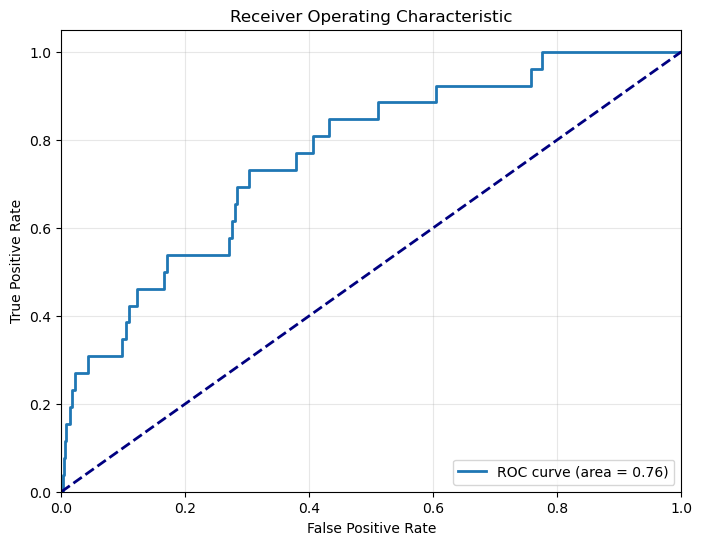

In [55]:
model = LogisticRegression()
C_parameter = np.logspace(-5, 5, 20)
#C_parameter = [1.1e-24]
param_grid = {
    'penalty' : ['l2'],
    'C' : C_parameter,
    'solver' : ['lbfgs'],
    'max_iter' : [10000],
    'class_weight'  : [None]
    }

X_train_std, X_test_std, y_train_std, y_test_std
# Initialize GridSearchCV with cross-validation
grid_search_reg_death = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_reg_death.fit(X_train_std, y_train_std['within90Days'])

# Extract the grid search results
results_reg_death = pd.DataFrame(grid_search_reg_death.cv_results_)

best_model_reg_death = grid_search_reg_death.best_estimator_
best_params_reg_death = grid_search_reg_death.best_params_


threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_reg_death = best_model_reg_death.predict_proba(X_test_std)[:,1]
y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_reg_death = f1_score(y_test_std['within90Days'], y_pred_binary_reg_death, average='binary')
holdout_accuracy_reg_death = accuracy_score(y_test_std['within90Days'], y_pred_binary_reg_death) * 100
holdout_precision_reg_death = precision_score(y_test_std['within90Days'], y_pred_binary_reg_death) * 100
holdout_recall_reg_death = recall_score(y_test_std['within90Days'], y_pred_binary_reg_death) * 100
holdout_auc_reg_death = roc_auc_score(y_test_std['within90Days'], y_pred_reg_death) * 100  # Use probabilities for AUC

# Print the summary
print('Death')
print(f"Best parameters: {best_params_reg_death}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_reg_death:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_reg_death:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_reg_death:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_reg_death:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_reg_death:.2f}%")


fpr, tpr, _ = roc_curve(y_test_std['within90Days'], y_pred_reg_death)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Respirator

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Respirator
Best parameters: {'C': 784.7599703514607, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score on Holdout Set: 0.2927
Holdout Set Accuracy: 77.63%
Holdout Set Precision: 49.32%
Holdout Set Recall: 20.81%
Holdout Set ROC AUC: 67.14%


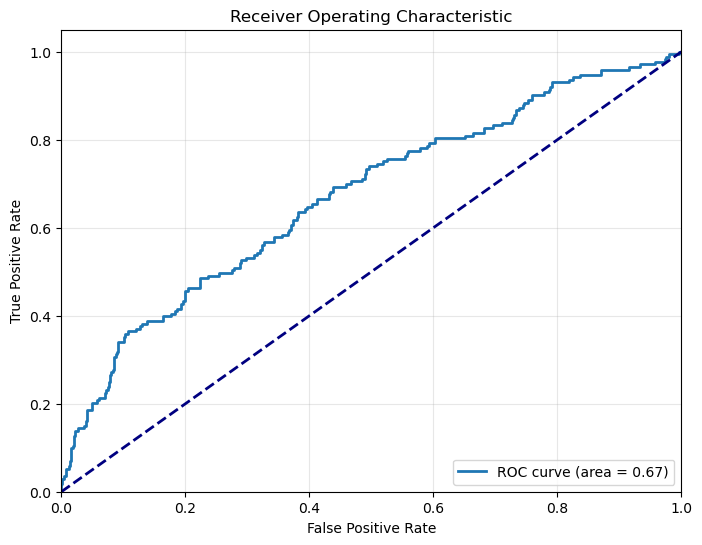

In [9]:

grid_search_reg_respirator = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_reg_respirator.fit(X_train_std, y_train_std['ventilatorTime6h'])

# Extract the grid search results
results_reg_respirator = grid_search_reg_respirator.cv_results_

best_model_reg_respirator = grid_search_reg_respirator.best_estimator_
best_params_reg_respirator = grid_search_reg_respirator.best_params_


threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_reg_respirator = best_model_reg_respirator.predict_proba(X_test_std)[:,1]
y_pred_binary_reg_respirator = (y_pred_reg_respirator >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_reg_respirator = f1_score(y_test_std['ventilatorTime6h'], y_pred_binary_reg_respirator, average='binary')
holdout_accuracy_reg_respirator = accuracy_score(y_test_std['ventilatorTime6h'], y_pred_binary_reg_respirator) * 100
holdout_precision_reg_respirator = precision_score(y_test_std['ventilatorTime6h'], y_pred_binary_reg_respirator) * 100
holdout_recall_reg_respirator = recall_score(y_test_std['ventilatorTime6h'], y_pred_binary_reg_respirator) * 100
holdout_auc_reg_respirator = roc_auc_score(y_test_std['ventilatorTime6h'], y_pred_reg_respirator) * 100  # Use probabilities for AUC


# Print the summary
print('Respirator')
print(f"Best parameters: {best_params_reg_respirator}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_reg_respirator:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_reg_respirator:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_reg_respirator:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_reg_respirator:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_reg_respirator:.2f}%")

fpr, tpr, _ = roc_curve(y_test_std['ventilatorTime6h'], y_pred_reg_respirator)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


AKI

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 0.04832930238571752, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score on Holdout Set: 0.6250
Holdout Set Accuracy: 66.84%
Holdout Set Precision: 65.95%
Holdout Set Recall: 59.39%
Holdout Set ROC AUC: 73.21%


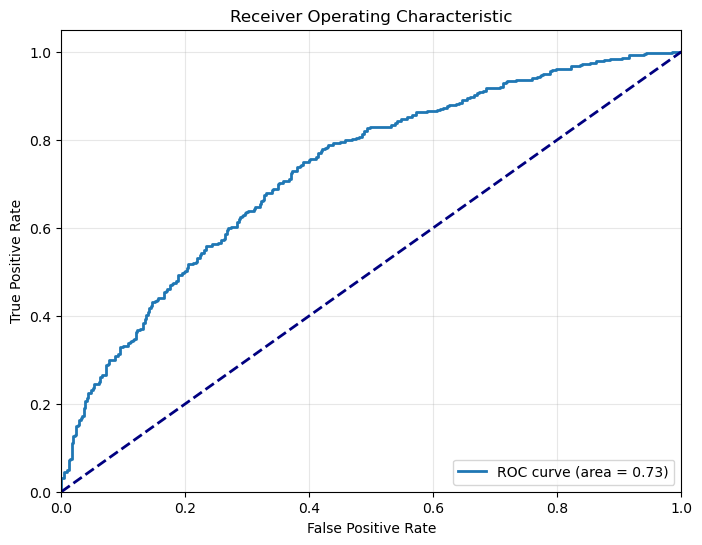

In [10]:
grid_search_reg_AKI = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_reg_AKI.fit(X_train_std, y_train_std['AKI'])

# Extract the grid search results
results_reg_AKI = grid_search_reg_AKI.cv_results_

best_model_reg_AKI = grid_search_reg_AKI.best_estimator_
best_params_reg_AKI = grid_search_reg_AKI.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_reg_AKI = best_model_reg_AKI.predict_proba(X_test_std)[:,1]
y_pred_binary_reg_AKI = (y_pred_reg_AKI >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_reg_AKI = f1_score(y_test_std['AKI'], y_pred_binary_reg_AKI, average='binary')
holdout_accuracy_reg_AKI = accuracy_score(y_test_std['AKI'], y_pred_binary_reg_AKI) * 100
holdout_precision_reg_AKI = precision_score(y_test_std['AKI'], y_pred_binary_reg_AKI) * 100
holdout_recall_reg_AKI = recall_score(y_test_std['AKI'], y_pred_binary_reg_AKI) * 100
holdout_auc_reg_AKI = roc_auc_score(y_test_std['AKI'], y_pred_reg_AKI) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_reg_AKI}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_reg_AKI:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_reg_AKI:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_reg_AKI:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_reg_AKI:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_reg_AKI:.2f}%")

fpr, tpr, _ = roc_curve(y_test_std['AKI'], y_pred_reg_AKI)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Classification tree

Death

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None}
Final Model F1 Score on Holdout Set: 0.0784
Holdout Set Accuracy: 93.96%
Holdout Set Precision: 8.00%
Holdout Set Recall: 7.69%
Holdout Set ROC AUC: 51.83%


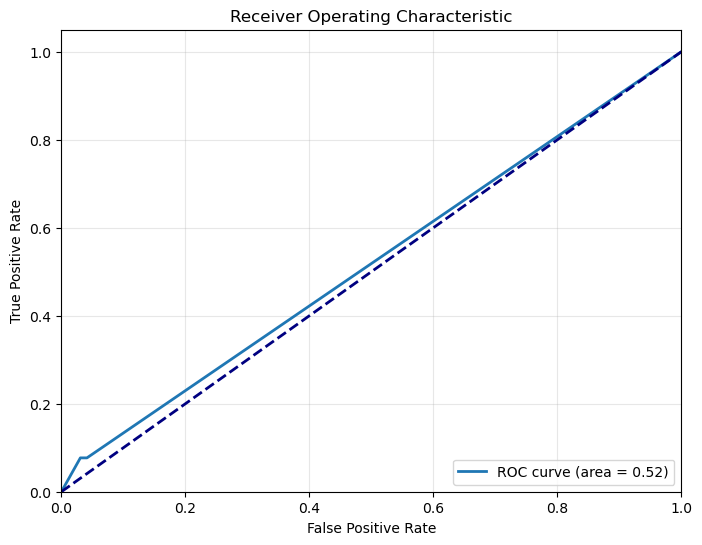

In [11]:
model = DecisionTreeClassifier(random_state=0)

param_grid = {
    'criterion': ['entropy'],
    'max_depth': [None, 5, 10, 15, 20],              
    'max_features': [None],  #None
    'class_weight': [None],   #None
}


X_train_std, X_test_std, y_train_std, y_test_std
# Initialize GridSearchCV with cross-validation
grid_search_tree_death = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_tree_death.fit(X_train_norm, y_train_norm['within90Days'])

# Extract the grid search results
results_tree_death = grid_search_tree_death.cv_results_

best_model_tree_death = grid_search_tree_death.best_estimator_
best_params_tree_death = grid_search_tree_death.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_tree_death = best_model_tree_death.predict_proba(X_test_norm)[:,1]
y_pred_binary_tree_death = (y_pred_tree_death >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_tree_death = f1_score(y_test_norm['within90Days'], y_pred_binary_tree_death, average='binary')
holdout_accuracy_tree_death = accuracy_score(y_test_norm['within90Days'], y_pred_binary_tree_death) * 100
holdout_precision_tree_death = precision_score(y_test_norm['within90Days'], y_pred_binary_tree_death) * 100
holdout_recall_tree_death = recall_score(y_test_norm['within90Days'], y_pred_binary_tree_death) * 100
holdout_auc_tree_death = roc_auc_score(y_test_norm['within90Days'], y_pred_tree_death) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_tree_death}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_tree_death:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_tree_death:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_tree_death:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_tree_death:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_tree_death:.2f}%")

fpr, tpr, _ = roc_curve(y_test_norm['within90Days'], y_pred_tree_death)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Respirator

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None}
Final Model F1 Score on Holdout Set: 0.1212
Holdout Set Accuracy: 77.63%
Holdout Set Precision: 48.00%
Holdout Set Recall: 6.94%
Holdout Set ROC AUC: 53.87%


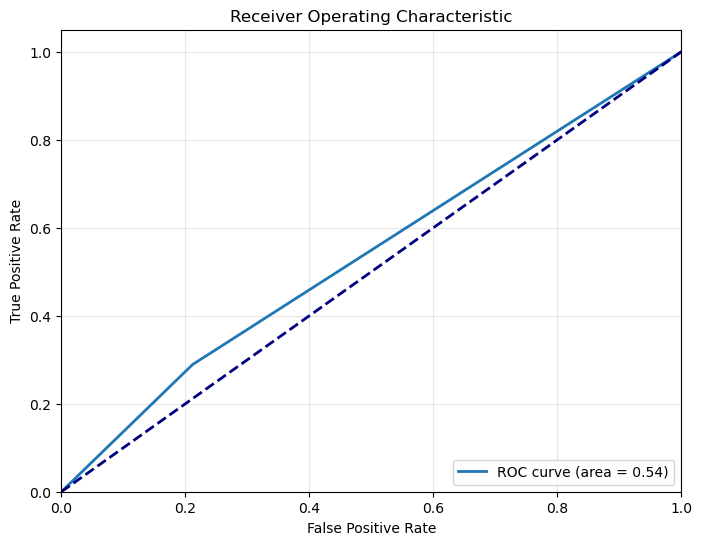

In [12]:

grid_search_tree_respirator = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_tree_respirator.fit(X_train_norm, y_train_norm['ventilatorTime6h'])

# Extract the grid search results
results_tree_respirator = grid_search_tree_respirator.cv_results_

best_model_tree_respirator = grid_search_tree_respirator.best_estimator_
best_params_tree_respirator = grid_search_tree_respirator.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_tree_respirator = best_model_tree_respirator.predict_proba(X_test_norm)[:,1]
y_pred_binary_tree_respirator = (y_pred_tree_death >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_tree_respirator = f1_score(y_test_norm['ventilatorTime6h'], y_pred_binary_tree_respirator, average='binary')
holdout_accuracy_tree_respirator = accuracy_score(y_test_norm['ventilatorTime6h'], y_pred_binary_tree_respirator) * 100
holdout_precision_tree_respirator = precision_score(y_test_norm['ventilatorTime6h'], y_pred_binary_tree_respirator) * 100
holdout_recall_tree_respirator = recall_score(y_test_norm['ventilatorTime6h'], y_pred_binary_tree_respirator) * 100
holdout_auc_tree_respirator = roc_auc_score(y_test_norm['ventilatorTime6h'], y_pred_tree_respirator) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_tree_respirator}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_tree_respirator:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_tree_respirator:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_tree_respirator:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_tree_respirator:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_tree_respirator:.2f}%")

fpr, tpr, _ = roc_curve(y_test_norm['ventilatorTime6h'], y_pred_tree_respirator)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

AKI

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None}
Final Model F1 Score on Holdout Set: 0.5626
Holdout Set Accuracy: 60.03%
Holdout Set Precision: 57.31%
Holdout Set Recall: 55.25%
Holdout Set ROC AUC: 59.72%


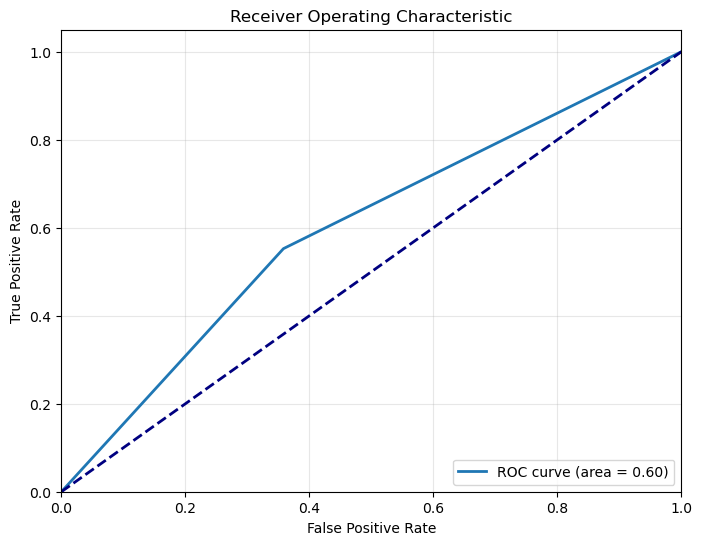

In [13]:
grid_search_tree_AKI = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_tree_AKI.fit(X_train_norm, y_train_norm['AKI'])

# Extract the grid search results
results_tree_AKI = grid_search_tree_AKI.cv_results_

best_model_tree_AKI = grid_search_tree_AKI.best_estimator_
best_params_tree_AKI = grid_search_tree_AKI.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_tree_AKI = best_model_tree_AKI.predict_proba(X_test_norm)[:,1]
y_pred_binary_tree_AKI = (y_pred_tree_AKI >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_tree_AKI = f1_score(y_test_norm['AKI'], y_pred_binary_tree_AKI, average='binary')
holdout_accuracy_tree_AKI = accuracy_score(y_test_norm['AKI'], y_pred_binary_tree_AKI) * 100
holdout_precision_tree_AKI = precision_score(y_test_norm['AKI'], y_pred_binary_tree_AKI) * 100
holdout_recall_tree_AKI = recall_score(y_test_norm['AKI'], y_pred_binary_tree_AKI) * 100
holdout_auc_tree_AKI = roc_auc_score(y_test_norm['AKI'], y_pred_tree_AKI) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_tree_AKI}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_tree_AKI:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_tree_AKI:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_tree_AKI:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_tree_AKI:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_tree_AKI:.2f}%")

fpr, tpr, _ = roc_curve(y_test_norm['AKI'], y_pred_tree_AKI)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Multi-Layer Perceptron

Death

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.00011288378916846884, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Final Model F1 Score on Holdout Set: 0.1667
Holdout Set Accuracy: 94.86%
Holdout Set Precision: 18.18%
Holdout Set Recall: 15.38%
Holdout Set ROC AUC: 71.67%


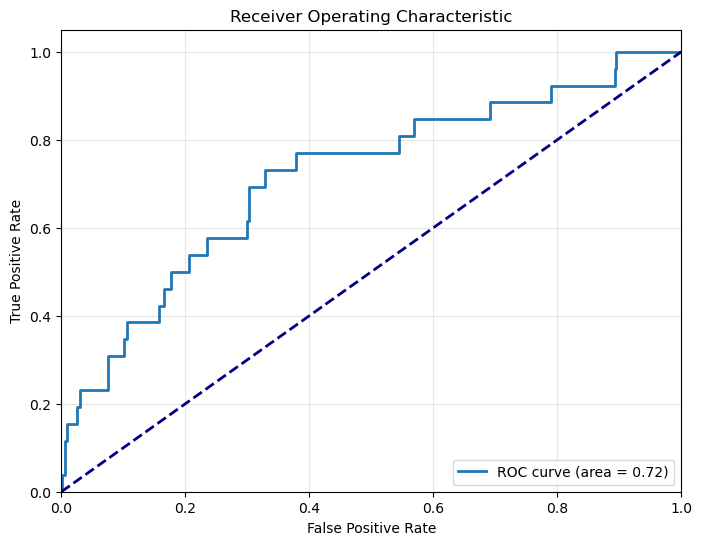

In [15]:
#Standardize data for anns as well as regression models

model = MLPClassifier(max_iter=1000, random_state=0) #Increase max_iter

param_grid = {
    'hidden_layer_sizes': [(2,), (5,), (10,)], #potentially not 15 20
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': C_parameter, #Do the same as regression C_parameter
    'learning_rate_init': [0.001, 0.01, 0.1] 
}


X_train_std, X_test_std, y_train_std, y_test_std
# Initialize GridSearchCV with cross-validation
grid_search_mlp_death = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_mlp_death.fit(X_train_std, y_train_std['within90Days'])

# Extract the grid search results
results_mlp_death = grid_search_mlp_death.cv_results_

best_model_mlp_death = grid_search_mlp_death.best_estimator_
best_params_mlp_death = grid_search_mlp_death.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_mlp_death = best_model_mlp_death.predict_proba(X_test_std)[:,1]
y_pred_binary_mlp_death = (y_pred_mlp_death >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_mlp_death = f1_score(y_test_std['within90Days'], y_pred_binary_mlp_death, average='binary')
holdout_accuracy_mlp_death = accuracy_score(y_test_std['within90Days'], y_pred_binary_mlp_death) * 100
holdout_precision_mlp_death = precision_score(y_test_std['within90Days'], y_pred_binary_mlp_death) * 100
holdout_recall_mlp_death = recall_score(y_test_std['within90Days'], y_pred_binary_mlp_death) * 100
holdout_auc_mlp_death = roc_auc_score(y_test_std['within90Days'], y_pred_mlp_death) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_mlp_death}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_mlp_death:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_mlp_death:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_mlp_death:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_mlp_death:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_mlp_death:.2f}%")

fpr, tpr, _ = roc_curve(y_test_std['within90Days'], y_pred_mlp_death)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Respirator

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.1, 'solver': 'adam'}
Final Model F1 Score on Holdout Set: 0.3251
Holdout Set Accuracy: 75.45%
Holdout Set Precision: 41.82%
Holdout Set Recall: 26.59%
Holdout Set ROC AUC: 63.81%


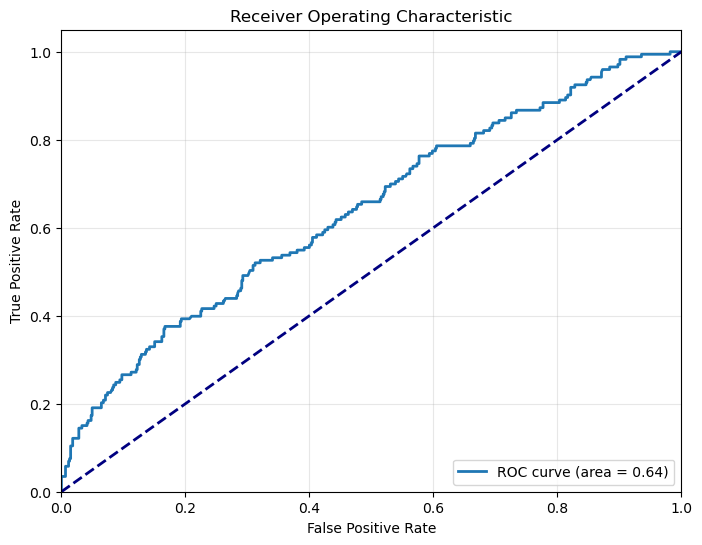

In [16]:

grid_search_mlp_respirator = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_mlp_respirator.fit(X_train_std, y_train_std['ventilatorTime6h'])

# Extract the grid search results
results_mlp_respirator = grid_search_mlp_respirator.cv_results_

best_model_mlp_respirator = grid_search_mlp_respirator.best_estimator_
best_params_mlp_respirator = grid_search_mlp_respirator.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_mlp_respirator = best_model_mlp_respirator.predict_proba(X_test_std)[:,1]
y_pred_binary_mlp_respirator = (y_pred_mlp_respirator >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_mlp_respirator = f1_score(y_test_std['ventilatorTime6h'], y_pred_binary_mlp_respirator, average='binary')
holdout_accuracy_mlp_respirator = accuracy_score(y_test_std['ventilatorTime6h'], y_pred_binary_mlp_respirator) * 100
holdout_precision_mlp_respirator = precision_score(y_test_std['ventilatorTime6h'], y_pred_binary_mlp_respirator) * 100
holdout_recall_mlp_respirator = recall_score(y_test_std['ventilatorTime6h'], y_pred_binary_mlp_respirator) * 100
holdout_auc_mlp_respirator = roc_auc_score(y_test_std['ventilatorTime6h'], y_pred_mlp_respirator) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_mlp_respirator}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_mlp_respirator:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_mlp_respirator:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_mlp_respirator:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_mlp_respirator:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_mlp_respirator:.2f}%")

fpr, tpr, _ = roc_curve(y_test_std['ventilatorTime6h'], y_pred_mlp_respirator)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

AKI

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 0.1623776739188721, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.1, 'solver': 'adam'}
Final Model F1 Score on Holdout Set: 0.5685
Holdout Set Accuracy: 62.72%
Holdout Set Precision: 61.61%
Holdout Set Recall: 52.76%
Holdout Set ROC AUC: 69.89%


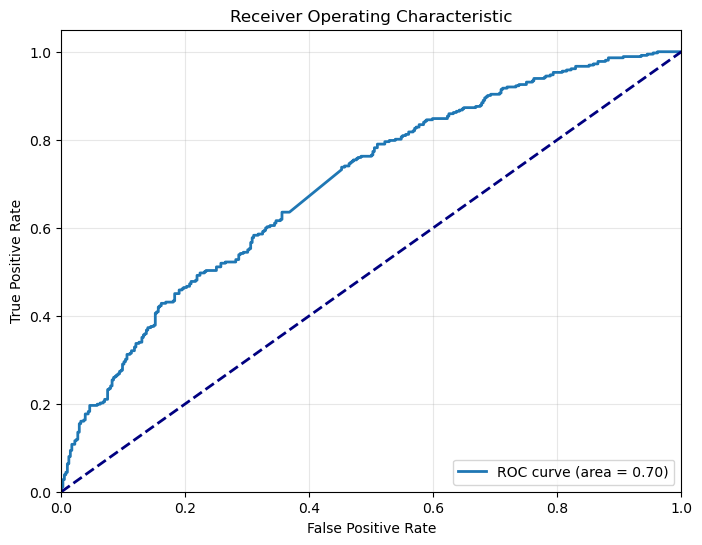

In [17]:

grid_search_mlp_AKI = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_mlp_AKI.fit(X_train_std, y_train_std['AKI'])

# Extract the grid search results
results_mlp_AKI = grid_search_mlp_AKI.cv_results_

best_model_mlp_AKI = grid_search_mlp_AKI.best_estimator_
best_params_mlp_AKI = grid_search_mlp_AKI.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_mlp_AKI = best_model_mlp_AKI.predict_proba(X_test_std)[:,1]
y_pred_binary_mlp_AKI = (y_pred_mlp_AKI >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_mlp_AKI = f1_score(y_test_std['AKI'], y_pred_binary_mlp_AKI, average='binary')
holdout_accuracy_mlp_AKI = accuracy_score(y_test_std['AKI'], y_pred_binary_mlp_AKI) * 100
holdout_precision_mlp_AKI = precision_score(y_test_std['AKI'], y_pred_binary_mlp_AKI) * 100
holdout_recall_mlp_AKI = recall_score(y_test_std['AKI'], y_pred_binary_mlp_AKI) * 100
holdout_auc_mlp_AKI = roc_auc_score(y_test_std['AKI'], y_pred_mlp_AKI) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_mlp_AKI}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_mlp_AKI:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_mlp_AKI:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_mlp_AKI:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_mlp_AKI:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_mlp_AKI:.2f}%")

fpr, tpr, _ = roc_curve(y_test_std['AKI'], y_pred_mlp_AKI)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### XGBoost

Death

Fitting 10 folds for each of 18 candidates, totalling 180 fits


C:\Users\CLUN0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [10:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 1}
Final Model F1 Score on Holdout Set: 0.0000
Holdout Set Accuracy: 96.66%
Holdout Set Precision: 0.00%
Holdout Set Recall: 0.00%
Holdout Set ROC AUC: 80.54%


c:\Program Files\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


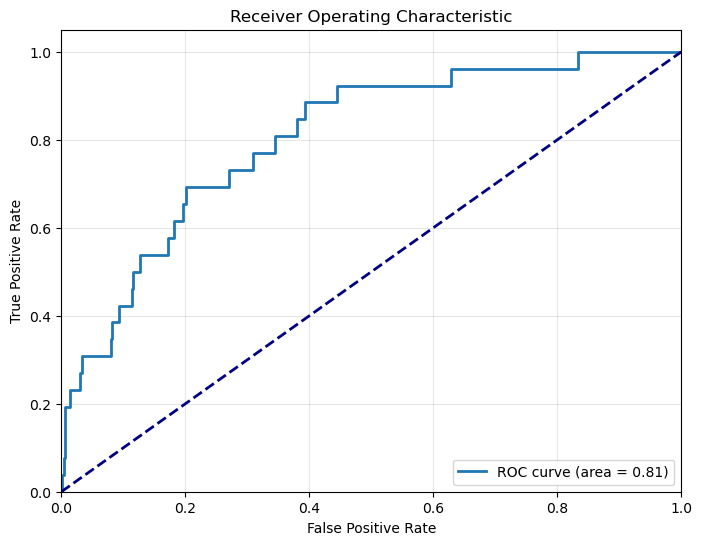

In [18]:
# Define a simple parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 200],
    #'scale_pos_weight': [0.75 * scale_pos_weight, scale_pos_weight, 1.25 * scale_pos_weight],
    'reg_alpha': [1],
    'reg_lambda': [1]
}



model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='f1')
# Initialize GridSearchCV with cross-validation
grid_search_XGB_death = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model for 'within90Days' target
grid_search_XGB_death.fit(X_train_norm, y_train_norm['within90Days'])


# Extract the grid search results for 'within90Days'
results_XGB_death = grid_search_XGB_death.cv_results_

best_model_XGB_death = grid_search_XGB_death.best_estimator_
best_params_XGB_death = grid_search_XGB_death.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_XGB_death = best_model_XGB_death.predict_proba(X_test_norm)[:,1]
y_pred_binary_XGB_death = (y_pred_XGB_death >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_XGB_death = f1_score(y_test_norm['within90Days'], y_pred_binary_XGB_death, average='binary')
holdout_accuracy_XGB_death = accuracy_score(y_test_norm['within90Days'], y_pred_binary_XGB_death) * 100
holdout_precision_XGB_death = precision_score(y_test_norm['within90Days'], y_pred_binary_XGB_death) * 100
holdout_recall_XGB_death = recall_score(y_test_norm['within90Days'], y_pred_binary_XGB_death) * 100
holdout_auc_XGB_death = roc_auc_score(y_test_norm['within90Days'], y_pred_XGB_death) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_XGB_death}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_XGB_death:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_XGB_death:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_XGB_death:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_XGB_death:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_XGB_death:.2f}%")

fpr, tpr, _ = roc_curve(y_test_norm['within90Days'], y_pred_XGB_death)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Respirator

Fitting 10 folds for each of 18 candidates, totalling 180 fits


C:\Users\CLUN0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [10:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
Final Model F1 Score on Holdout Set: 0.2759
Holdout Set Accuracy: 78.41%
Holdout Set Precision: 54.24%
Holdout Set Recall: 18.50%
Holdout Set ROC AUC: 67.92%


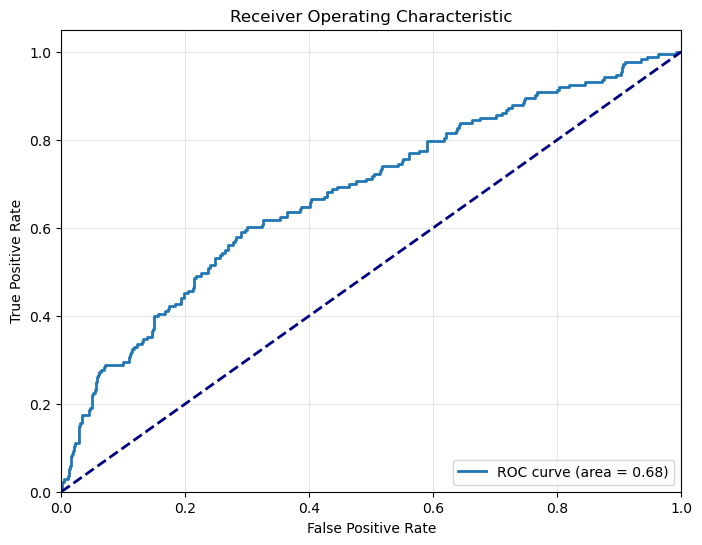

In [19]:

# Similarly, you can define and fit grid search for other outcomes

# GridSearch for 'ventilatorTime6h'
grid_search_XGB_respirator = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
grid_search_XGB_respirator.fit(X_train_norm, y_train_norm['ventilatorTime6h'])
results_XGB_respirator = grid_search_XGB_respirator.cv_results_

best_model_XGB_respirator = grid_search_XGB_respirator.best_estimator_
best_params_XGB_respirator = grid_search_XGB_respirator.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_XGB_respirator = best_model_XGB_respirator.predict_proba(X_test_norm)[:,1]
y_pred_binary_XGB_respirator = (y_pred_XGB_respirator >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_XGB_respirator = f1_score(y_test_norm['ventilatorTime6h'], y_pred_binary_XGB_respirator, average='binary')
holdout_accuracy_XGB_respirator = accuracy_score(y_test_norm['ventilatorTime6h'], y_pred_binary_XGB_respirator) * 100
holdout_precision_XGB_respirator = precision_score(y_test_norm['ventilatorTime6h'], y_pred_binary_XGB_respirator) * 100
holdout_recall_XGB_respirator = recall_score(y_test_norm['ventilatorTime6h'], y_pred_binary_XGB_respirator) * 100
holdout_auc_XGB_respirator = roc_auc_score(y_test_norm['ventilatorTime6h'], y_pred_XGB_respirator) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_XGB_respirator}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_XGB_respirator:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_XGB_respirator:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_XGB_respirator:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_XGB_respirator:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_XGB_respirator:.2f}%")

fpr, tpr, _ = roc_curve(y_test_norm['ventilatorTime6h'], y_pred_XGB_respirator)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

AKI

Fitting 10 folds for each of 18 candidates, totalling 180 fits


C:\Users\CLUN0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [10:22:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1}
Final Model F1 Score on Holdout Set: 0.6528
Holdout Set Accuracy: 67.87%
Holdout Set Precision: 65.64%
Holdout Set Recall: 64.92%
Holdout Set ROC AUC: 75.60%


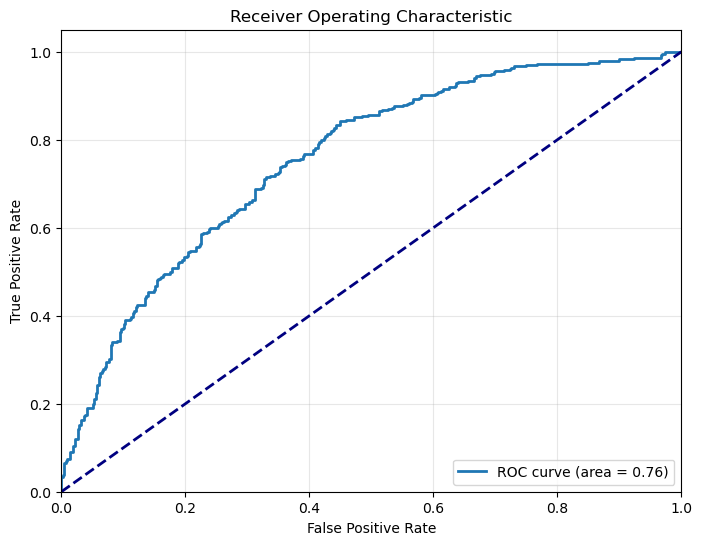

In [20]:

# GridSearch for 'AKI'
grid_search_XGB_AKI = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
grid_search_XGB_AKI.fit(X_train_norm, y_train_norm['AKI'])
results_XGB_AKI = grid_search_XGB_AKI.cv_results_

best_model_XGB_AKI = grid_search_XGB_AKI.best_estimator_
best_params_XGB_AKI = grid_search_XGB_AKI.best_params_

threshold = 0.5  # Example threshold, adjust as appropriate
# Evaluate the model on the holdout set
y_pred_XGB_AKI = best_model_XGB_AKI.predict_proba(X_test_norm)[:,1]
y_pred_binary_XGB_AKI = (y_pred_XGB_AKI >= threshold).astype(int)

#y_pred_binary_reg_death = (y_pred_reg_death >= threshold).astype(int)
#y_test_binary_ = (y_test_std['within90Days'] >= threshold).astype(int)

# Calculate metrics
holdout_f1_XGB_AKI = f1_score(y_test_norm['AKI'], y_pred_binary_XGB_AKI, average='binary')
holdout_accuracy_XGB_AKI = accuracy_score(y_test_norm['AKI'], y_pred_binary_XGB_AKI) * 100
holdout_precision_XGB_AKI = precision_score(y_test_norm['AKI'], y_pred_binary_XGB_AKI) * 100
holdout_recall_XGB_AKI = recall_score(y_test_norm['AKI'], y_pred_binary_XGB_AKI) * 100
holdout_auc_XGB_AKI = roc_auc_score(y_test_norm['AKI'], y_pred_XGB_AKI) * 100  # Use probabilities for AUC

# Print the summary
print(f"Best parameters: {best_params_XGB_AKI}")
print(f"Final Model F1 Score on Holdout Set: {holdout_f1_XGB_AKI:.4f}")
print(f"Holdout Set Accuracy: {holdout_accuracy_XGB_AKI:.2f}%")
print(f"Holdout Set Precision: {holdout_precision_XGB_AKI:.2f}%")
print(f"Holdout Set Recall: {holdout_recall_XGB_AKI:.2f}%")
print(f"Holdout Set ROC AUC: {holdout_auc_XGB_AKI:.2f}%")

fpr, tpr, _ = roc_curve(y_test_norm['AKI'], y_pred_XGB_AKI)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

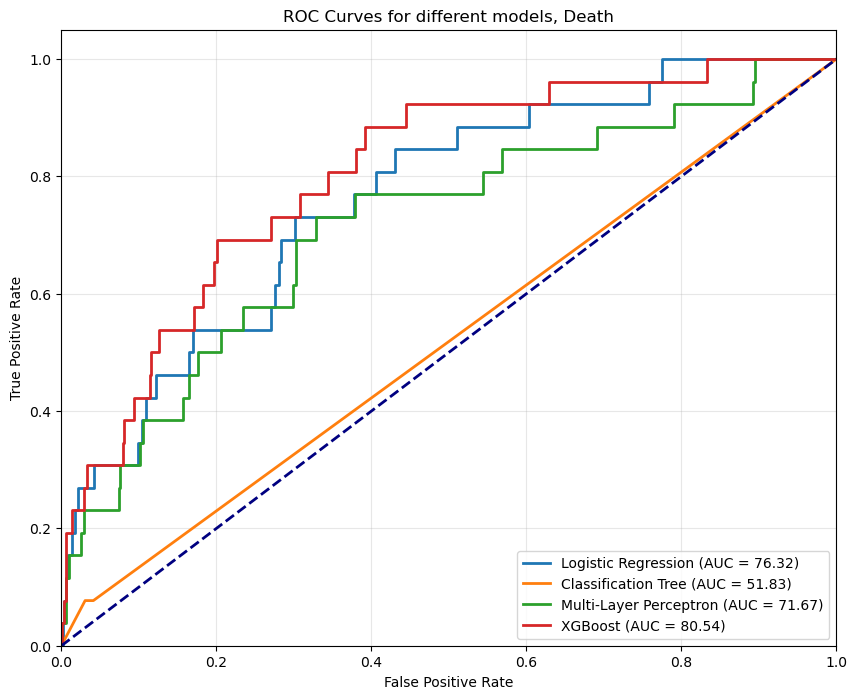

In [56]:
model_names = ["Logistic Regression", 
               "Classification Tree", 
               "Multi-Layer Perceptron", 
               "XGBoost"]


plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test_std['within90Days'], y_pred_reg_death)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[0]} (AUC = {holdout_auc_reg_death:.2f})')
fpr, tpr, _ = roc_curve(y_test_norm['within90Days'], y_pred_tree_death)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[1]} (AUC = {holdout_auc_tree_death:.2f})')
fpr, tpr, _ = roc_curve(y_test_std['within90Days'], y_pred_mlp_death)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[2]} (AUC = {holdout_auc_mlp_death:.2f})')
fpr, tpr, _ = roc_curve(y_test_norm['within90Days'], y_pred_XGB_death)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[3]} (AUC = {holdout_auc_XGB_death:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for different models, Death')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

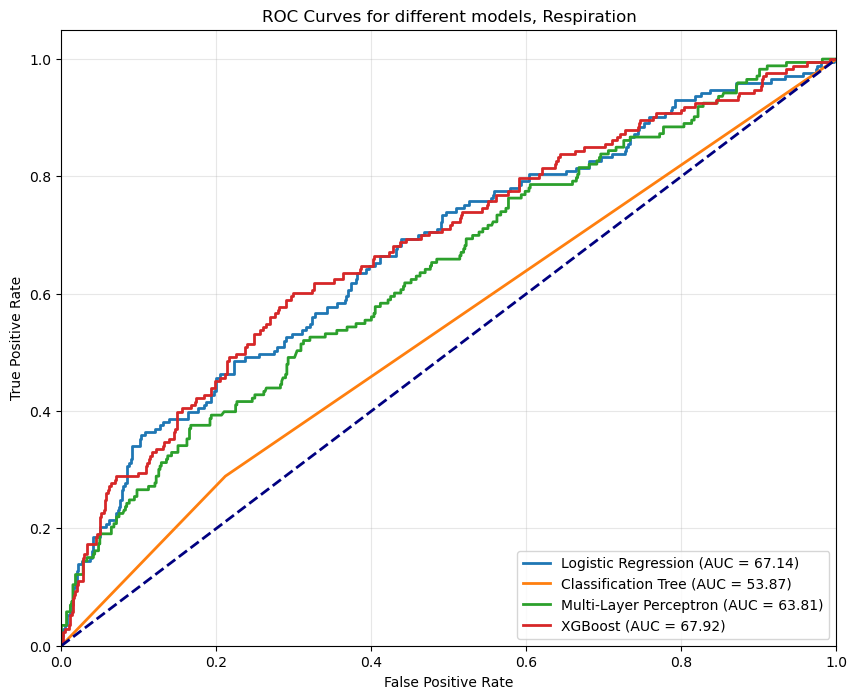

In [57]:
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test_std['ventilatorTime6h'], y_pred_reg_respirator)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[0]} (AUC = {holdout_auc_reg_respirator:.2f})')

fpr, tpr, _ = roc_curve(y_test_norm['ventilatorTime6h'], y_pred_tree_respirator)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[1]} (AUC = {holdout_auc_tree_respirator:.2f})')

fpr, tpr, _ = roc_curve(y_test_std['ventilatorTime6h'], y_pred_mlp_respirator)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[2]} (AUC = {holdout_auc_mlp_respirator:.2f})')

fpr, tpr, _ = roc_curve(y_test_norm['ventilatorTime6h'], y_pred_XGB_respirator)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[3]} (AUC = {holdout_auc_XGB_respirator:.2f})')

 # Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for different models, Respiration')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

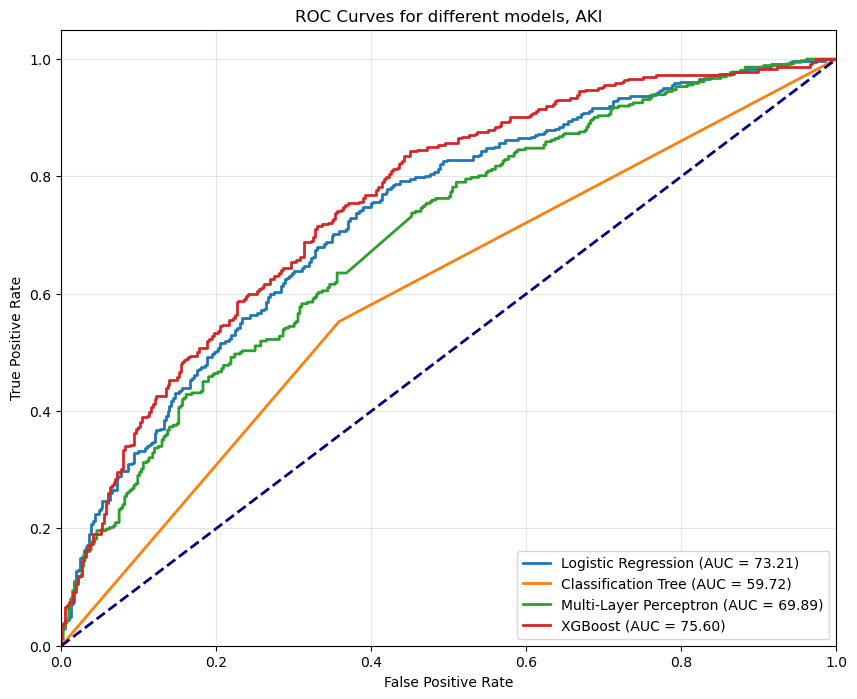

In [58]:
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test_std['AKI'], y_pred_reg_AKI)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[0]} (AUC = {holdout_auc_reg_AKI:.2f})')

fpr, tpr, _ = roc_curve(y_test_norm['AKI'], y_pred_tree_AKI)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[1]} (AUC = {holdout_auc_tree_AKI:.2f})')

fpr, tpr, _ = roc_curve(y_test_std['AKI'], y_pred_mlp_AKI)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[2]} (AUC = {holdout_auc_mlp_AKI:.2f})')

fpr, tpr, _ = roc_curve(y_test_norm['AKI'], y_pred_XGB_AKI)
plt.plot(fpr, tpr, lw=2, label=f'{model_names[3]} (AUC = {holdout_auc_XGB_AKI:.2f})')

 # Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for different models, AKI')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Regression

In [38]:
outcomeSTD = np.std(y_test_norm['TimeOfStayInDays'])
outcomeMean = np.mean(y_test_norm['TimeOfStayInDays'])

### Linear regression ridge

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'alpha': 2636.6508987303555}
Holdout Set Mean Absolute Error (MAE): 4.53
Holdout Set Mean Squared Error (MSE): 63.28
Holdout Set Root Mean Squared Error (RMSE): 7.95
Holdout Set R² Score: 0.1945


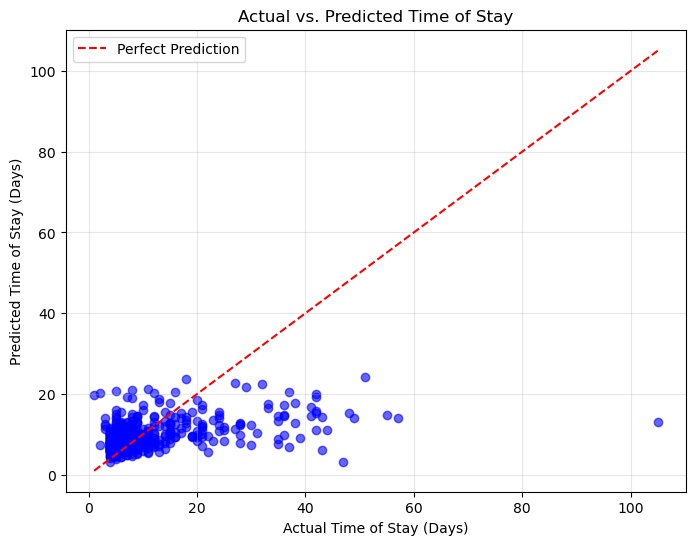

" grid_search_reg_op = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)\n\n# Fit the GridSearchCV model\ngrid_search_reg_op.fit(X_train_std, y_train_std['TimeOfOperationInMinutes'])\n\nresults_reg_op = grid_search_reg_op.cv_results_ "

In [40]:
model = Ridge()

alpha_parameter = np.logspace(-5, 5, 20)  # L2 regularization strength

param_grid = {
    'alpha': alpha_parameter  # Only parameter for Ridge regression
}

X_train_std, X_test_std, y_train_std, y_test_std
# Initialize GridSearchCV with cross-validation
grid_search_reg_stay = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'neg_mean_absolute_error', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_reg_stay.fit(X_train_std, y_train_std['TimeOfStayInDays'])

results_reg_stay = grid_search_reg_stay.cv_results_

best_model_reg_stay = grid_search_reg_stay.best_estimator_
best_params_reg_stay = grid_search_reg_stay.best_params_

# Evaluate the model on the holdout set
y_pred_reg_stay = best_model_reg_stay.predict(X_test_std)

# Calculate metrics
y_pred_reg_stay = (y_pred_reg_stay * outcomeSTD) + outcomeMean

holdout_mae_reg_stay = mean_absolute_error(y_test_norm['TimeOfStayInDays'], y_pred_reg_stay)
holdout_mse_reg_stay = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_reg_stay)
holdout_rmse_reg_stay = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_reg_stay, squared=False)
holdout_r2_reg_stay = r2_score(y_test_norm['TimeOfStayInDays'], y_pred_reg_stay)

# Print the summary
print(f"Best parameters: {best_params_reg_stay}")
print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae_reg_stay:.2f}")
print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse_reg_stay:.2f}")
print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse_reg_stay:.2f}")
print(f"Holdout Set R² Score: {holdout_r2_reg_stay:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_norm['TimeOfStayInDays'], y_pred_reg_stay, alpha=0.6, color='blue')
plt.plot([min(y_test_norm['TimeOfStayInDays']), max(y_test_norm['TimeOfStayInDays'])],
         [min(y_test_norm['TimeOfStayInDays']), max(y_test_norm['TimeOfStayInDays'])],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Time of Stay (Days)')
plt.ylabel('Predicted Time of Stay (Days)')
plt.title('Actual vs. Predicted Time of Stay')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

""" grid_search_reg_op = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_reg_op.fit(X_train_std, y_train_std['TimeOfOperationInMinutes'])

results_reg_op = grid_search_reg_op.cv_results_ """

### Regression tree

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'max_depth': 5, 'max_features': None}
Holdout Set Mean Absolute Error (MAE): 4.47
Holdout Set Mean Squared Error (MSE): 65.49
Holdout Set Root Mean Squared Error (RMSE): 8.09
Holdout Set R² Score: 0.1663


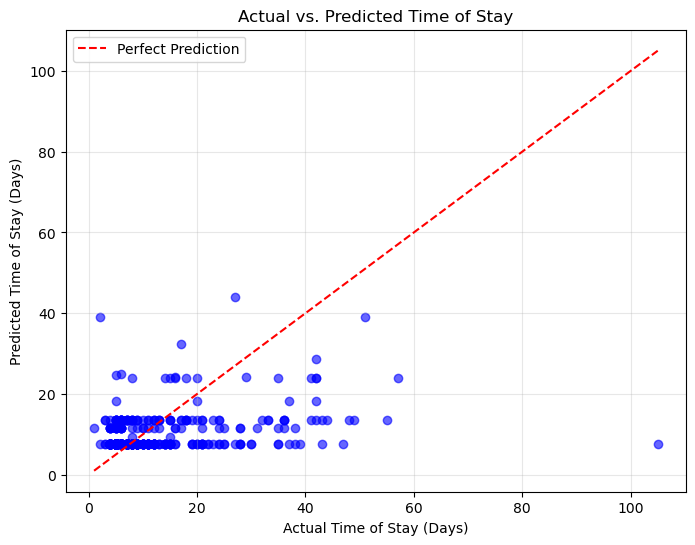

" grid_search_reg_op = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)\n\n# Fit the GridSearchCV model\ngrid_search_tree_op.fit(X_train_norm, y_train_norm['TimeOfOperationInMinutes'])\n\nresults_tree_op = grid_search_tree_op.cv_results_ "

In [22]:
model = DecisionTreeRegressor(random_state=0)
C_parameter = np.logspace(-5, 5, 20)
#C_parameter = [1.1e-24]
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],  #Use only one of these 3
    #'min_samples_split': [2, 5, 10, 20], #Use only one of these 3
    #'min_samples_leaf': [1, 5, 10, 20],  #Use only one of these 3
    'max_features': [None]  #Noneuse
}


X_train_std, X_test_std, y_train_std, y_test_std
# Initialize GridSearchCV with cross-validation
grid_search_tree_stay = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'neg_mean_absolute_error', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_tree_stay.fit(X_train_norm, y_train_norm['TimeOfStayInDays'])

results_tree_stay = grid_search_tree_stay.cv_results_

best_model_tree_stay = grid_search_tree_stay.best_estimator_
best_params_tree_stay = grid_search_tree_stay.best_params_

# Evaluate the model on the holdout set
y_pred_tree_stay = best_model_tree_stay.predict(X_test_norm)

# Calculate metrics
holdout_mae_tree_stay = mean_absolute_error(y_test_norm['TimeOfStayInDays'], y_pred_tree_stay)
holdout_mse_tree_stay = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_tree_stay)
holdout_rmse_tree_stay = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_tree_stay, squared=False)
holdout_r2_tree_stay = r2_score(y_test_norm['TimeOfStayInDays'], y_pred_tree_stay)

# Print the summary
print(f"Best parameters: {best_params_tree_stay}")
print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae_tree_stay:.2f}")
print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse_tree_stay:.2f}")
print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse_tree_stay:.2f}")
print(f"Holdout Set R² Score: {holdout_r2_tree_stay:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_norm['TimeOfStayInDays'], y_pred_tree_stay, alpha=0.6, color='blue')
plt.plot([min(y_test_norm['TimeOfStayInDays']), max(y_test_norm['TimeOfStayInDays'])],
         [min(y_test_norm['TimeOfStayInDays']), max(y_test_norm['TimeOfStayInDays'])],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Time of Stay (Days)')
plt.ylabel('Predicted Time of Stay (Days)')
plt.title('Actual vs. Predicted Time of Stay')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

""" grid_search_reg_op = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_tree_op.fit(X_train_norm, y_train_norm['TimeOfOperationInMinutes'])

results_tree_op = grid_search_tree_op.cv_results_ """

### Multi-Layer Perceptron

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 20.6913808111479, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001, 'solver': 'adam'}
Holdout Set Mean Absolute Error (MAE): 4.48
Holdout Set Mean Squared Error (MSE): 63.32
Holdout Set Root Mean Squared Error (RMSE): 7.96
Holdout Set R² Score: 0.1939


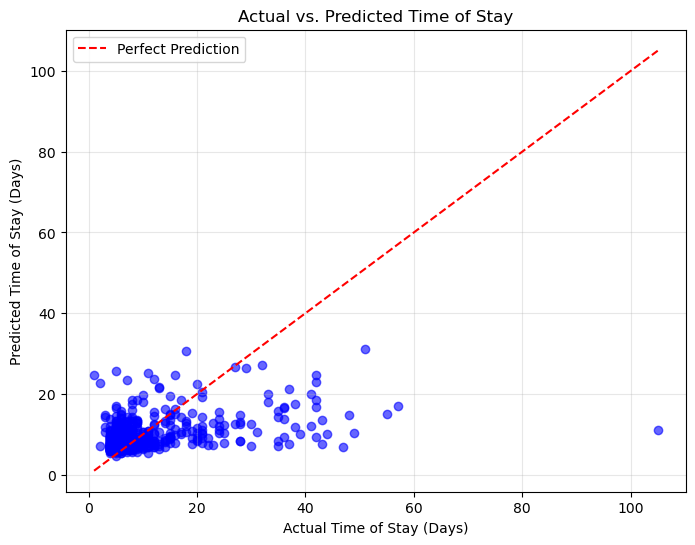

" grid_search_mlp_op = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)\n\n# Fit the GridSearchCV model\ngrid_search_mlp_op.fit(X_train_std, y_train_std['TimeOfOperationInMinutes'])\n\nresults_mlp_op = grid_search_mlp_op.cv_results_ "

In [41]:
model = MLPRegressor(max_iter=1000, random_state=0) #Increase max_iter

param_grid = {
    'hidden_layer_sizes': [(2,), (5,), (10,)], #potentially not 15 20
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': C_parameter, #Do the same as regression C_parameter
    'learning_rate_init': [0.001, 0.01, 0.1] 
}

X_train_std, X_test_std, y_train_std, y_test_std
# Initialize GridSearchCV with cross-validation
grid_search_mlp_stay = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'neg_mean_absolute_error', return_train_score=True, n_jobs=-1)


# Fit the GridSearchCV model
grid_search_mlp_stay.fit(X_train_std, y_train_std['TimeOfStayInDays'])

results_mlp_stay = grid_search_mlp_stay.cv_results_

best_model_mlp_stay = grid_search_mlp_stay.best_estimator_
best_params_mlp_stay = grid_search_mlp_stay.best_params_

# Evaluate the model on the holdout set
y_pred_mlp_stay = best_model_mlp_stay.predict(X_test_std)

# Calculate metrics
y_pred_mlp_stay = (y_pred_mlp_stay * outcomeSTD) + outcomeMean

holdout_mae_mlp_stay = mean_absolute_error(y_test_norm['TimeOfStayInDays'], y_pred_mlp_stay)
holdout_mse_mlp_stay = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_mlp_stay)
holdout_rmse_mlp_stay = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_mlp_stay, squared=False)
holdout_r2_mlp_stay = r2_score(y_test_norm['TimeOfStayInDays'], y_pred_mlp_stay)

# Print the summary
print(f"Best parameters: {best_params_mlp_stay}")
print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae_mlp_stay:.2f}")
print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse_mlp_stay:.2f}")
print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse_mlp_stay:.2f}")
print(f"Holdout Set R² Score: {holdout_r2_mlp_stay:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_norm['TimeOfStayInDays'], y_pred_mlp_stay, alpha=0.6, color='blue')
plt.plot([min(y_test_norm['TimeOfStayInDays']), max(y_test_norm['TimeOfStayInDays'])],
         [min(y_test_norm['TimeOfStayInDays']), max(y_test_norm['TimeOfStayInDays'])],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Time of Stay (Days)')
plt.ylabel('Predicted Time of Stay (Days)')
plt.title('Actual vs. Predicted Time of Stay')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

""" grid_search_mlp_op = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_mlp_op.fit(X_train_std, y_train_std['TimeOfOperationInMinutes'])

results_mlp_op = grid_search_mlp_op.cv_results_ """

### XGBoost

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
Holdout Set Mean Absolute Error (MAE): 4.56
Holdout Set Mean Squared Error (MSE): 65.99
Holdout Set Root Mean Squared Error (RMSE): 8.12
Holdout Set R² Score: 0.1600


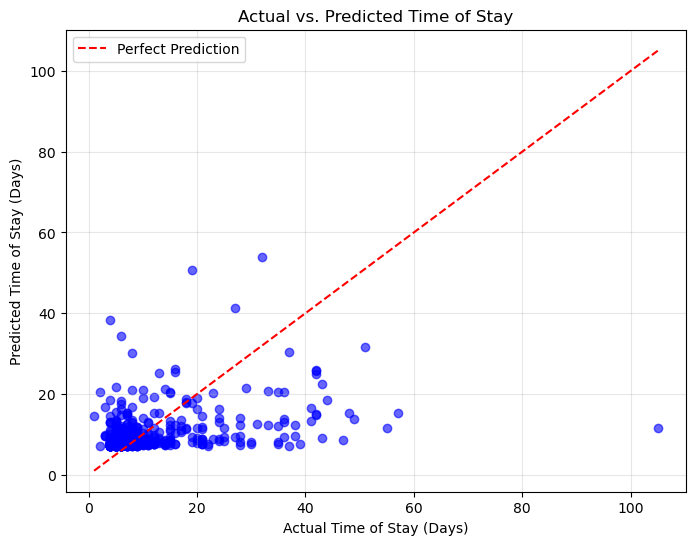

" grid_search_stay_op = GridSearchCV(model, param_grid, cv = 5, verbose = 4, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)\n\n# Fit the GridSearchCV model\ngrid_search_stay_op.fit(X_train_norm, y_train_norm['TimeOfOperationInMinutes'])\n\nresults_stay_op = grid_search_stay_op.cv_results_ "

In [ ]:
# Define a simple parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [5, 6, 7],           # Tree depth
    'learning_rate': [0.01, 0.1],     # Step size shrinkage
    'n_estimators': [50, 100, 200],   # Number of boosting rounds
    'reg_alpha': [1],                 # L1 regularization term
    'reg_lambda': [1]                 # L2 regularization term
}

# Define the XGBoost Regressor model
model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Initialize GridSearchCV for 'within90Days' target
grid_search_XGB_stay = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model for 'within90Days' target
grid_search_XGB_stay.fit(X_train_norm, y_train_norm['TimeOfStayInDays'])

# Extract the grid search results for 'within90Days'
results_XGB_stay = grid_search_reg_stay.cv_results_

best_model_XGB_stay = grid_search_XGB_stay.best_estimator_
best_params_XGB_stay = grid_search_XGB_stay.best_params_

# Evaluate the model on the holdout set
y_pred_XGB_stay = best_model_XGB_stay.predict(X_test_norm)

# Calculate metrics
holdout_mae_XGB_stay = mean_absolute_error(y_test_norm['TimeOfStayInDays'], y_pred_XGB_stay)
holdout_mse_XGB_stay = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_XGB_stay)
holdout_rmse_XGB_stay = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_XGB_stay, squared=False)
holdout_r2_XGB_stay = r2_score(y_test_norm['TimeOfStayInDays'], y_pred_XGB_stay)

# Print the summary
print(f"Best parameters: {best_params_XGB_stay}")
print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae_XGB_stay:.2f}")
print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse_XGB_stay:.2f}")
print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse_XGB_stay:.2f}")
print(f"Holdout Set R² Score: {holdout_r2_XGB_stay:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_norm['TimeOfStayInDays'], y_pred_XGB_stay, alpha=0.6, color='blue')
plt.plot([min(y_test_norm['TimeOfStayInDays']), max(y_test_norm['TimeOfStayInDays'])],
         [min(y_test_norm['TimeOfStayInDays']), max(y_test_norm['TimeOfStayInDays'])],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Time of Stay (Days)')
plt.ylabel('Predicted Time of Stay (Days)')
plt.title('Actual vs. Predicted Time of Stay')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

""" grid_search_stay_op = GridSearchCV(model, param_grid, cv = 10, verbose = 4, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)

# Fit the GridSearchCV model
grid_search_stay_op.fit(X_train_norm, y_train_norm['TimeOfOperationInMinutes'])

results_stay_op = grid_search_stay_op.cv_results_ """